# Extraction of the profile of the laser spots and the lamp


### Loading data:

In [1]:
using PIC

using Plots, StatsBase,Statistics, DelimitedFiles
using FITSIO
# wavelengths
λ1 = 987.72e-9;# laser 1
λ2 = 1123.71e-9;# laser 2
λ3 = 1309.37e-9;# laser 3
λ4 = 1545.10e-9;  # laser 4

# YJ observations
λlaser = [λ1,λ2,λ3];
nλ = length(λlaser);
λ0 = mean(λlaser);# reference


lampData =  read(FITS("/Users/ferreol/Data/SPHERE/HR_4796-HD_95086/IFS_calib_spec_corrected.fits")[1]);
laserData =  read(FITS("/Users/ferreol/Data/SPHERE/HR_4796-HD_95086/IFS_calib_wave_corrected.fits")[1]);
badpix = Float64.(read(FITS("/Users/ferreol/Data/SPHERE/HR_4796-HD_95086/IFS_BP_corrected.fits")[1]));



### Grab the median coefs computed by Anthony as initialization


In [2]:
coeffx = readdlm("/Users/ferreol/Data/SPHERE/HR_4796-HD_95086/coef_pol_x.txt", header = false)
cx0 = coeffx[:,1] .+ 1025;
mcx1 = median(coeffx[:,2])*λ0*1e6;
mcx2 = median(coeffx[:,3])*(λ0*1e6)^2;

coeffy = readdlm("/Users/ferreol/Data/SPHERE/HR_4796-HD_95086/coef_pol_y.txt", header = false)
cy0 = coeffy[:,1].+ 1025;
mcy1 = median(coeffy[:,2])*λ0*1e6;
mcy2 = median(coeffy[:,3])*(λ0*1e6)^2;


position = hcat(cx0, cy0);
cxinit = [mcx1;mcx2];
cyinit = [mcy1;mcy2];
lensletnumber= length(cx0);

### Lenslet bounding box size 

In [3]:

fwhminit = [2.3, 2.4 , 2.7];

#largeur = 4;
#hauteur = 44;
dxmin = 2;
dxmax = 2;
dymin = 21;
dymax = 18;
lensletsize = (dxmin, dxmax,dymin,dymax);

# removing cropped lenslets
validlenslet = ((cx0 .- dxmin).>0) .&  ((cx0 .+ dxmax).<2048) .&  ((cy0 .- dymin).>0) .&  ((cy0 .+ dymax).<2048);


### Sampling of the spectral law:

In [4]:
wavelengthrange = LinRange(850e-9,1600e-9,10000); # coarse wavelength range of the instrument


## Fitting the spectral dispertion law for each lenslet

The output contains 3 tables:
- `lenslettab` : the lenslet description (bounding box + spectral law)
- `atab` : the amplitude of each spots
- `fwhmtab` : the full-width at half maximum of each spots

and 2 maps:
- `distweight` : the distance of each pixel within a lenslet from to the spectral law
- `\lambdaMap` : the wavelenght seen by each pixels

In [5]:
(lenslettab,  atab, fwhmtab, distweight, λMap) = fitSpectralLaw(laserData,badpix,λlaser,lensletsize,position,cxinit,cyinit,fwhminit,wavelengthrange;validlenslets=validlenslet);


Progress: 100%|███████████████████████████| Time: 0:32:38 ( 0.10  s/it)


### Accounting for missing data

In [6]:

distweight[iszero.(badpix)].=missing;
λMap[iszero.(badpix)].=missing;

spotData = Array{Union{Float64,Missing}}(missing,2048,2048);
spotData .= laserData;
spotData[ismissing.(distweight)].=missing;

flatData = Array{Union{Float64,Missing}}(missing,2048,2048);
flatData .= lampData;
flatData[ismissing.(distweight)].=missing;

### Building histograms


In [21]:
using   LsqFit, Distributions
plotlyjs();


WebIO._IJuliaInit()

In [29]:
using StatsBase

Nspatial = 40;
Nspectral = 250;
hlaser = fit(Histogram,(collect(skipmissing(distweight[:])),collect(skipmissing(λMap[:].*1e6))),weights(collect(skipmissing(spotData[:]))),nbins=(Nspatial,Nspectral));
hflat = fit(Histogram,(collect(skipmissing(distweight[:])),collect(skipmissing(λMap[:].*1e6))),weights(collect(skipmissing(flatData[:]))),nbins=(Nspatial,Nspectral));

daxe = (hlaser.edges[1][2:end] + hlaser.edges[1][1:end-1])./2.;
λaxe = (hlaser.edges[2][2:end] + hlaser.edges[2][1:end-1])./2.;

In [34]:
#plot(contour(y=λaxe,x=daxe,z=hlaser.weights, contours_start=0, contours_end=1.8e6, contours_size=1e5))
using PlotlyJS
#PlotlyJS.plot(PlotlyJS.contour(y=λaxe,x=daxe,z=hlaser.weights))
PlotlyJS.plot(PlotlyJS.contour(x=λaxe,y=daxe,z=hlaser.weights, contours_start=0, contours_end=1.8e6, contours_size=5e4))

data: [
  "contour with fields contours, transpose, type, x, y, and z"
]

layout: "layout with fields margin and template"

In [35]:
PlotlyJS.plot(PlotlyJS.contour(x=λaxe,y=daxe,z=hflat.weights, contours_start=0, contours_end=10.5e6, contours_size=5e5))

data: [
  "contour with fields contours, transpose, type, x, y, and z"
]

layout: "layout with fields margin and template"

Gaussian model

In [11]:
m(t, p) = p[1] * exp.(- t.^2 ./p[2])
p0 = [1e7, 0.5];

### Fitting spots 

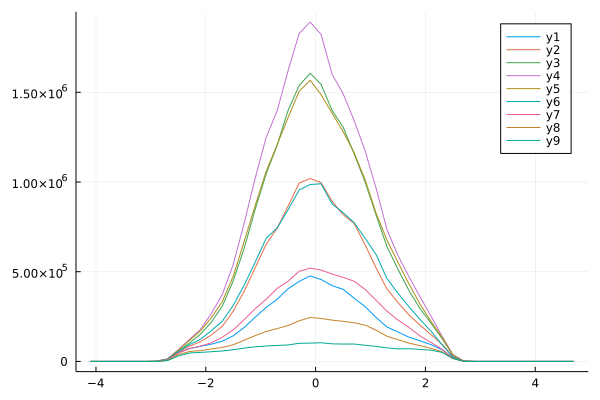

In [12]:
s1 = findfirst(x->x>λ1*1e6,λaxe);
plot(daxe,hlaser.weights[:,s1-4:s1+4],name=reshape([" $(i) " for i in λaxe[s1-4:s1+4] ],1,9))

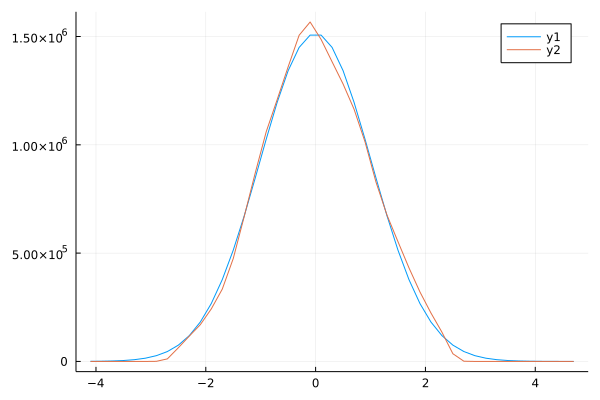

In [13]:


fittedlaser1 = curve_fit(m, daxe, hlaser.weights[:,s1], p0);
plot(daxe,hcat(m(daxe, fittedlaser1.param),hlaser.weights[:,s1]))

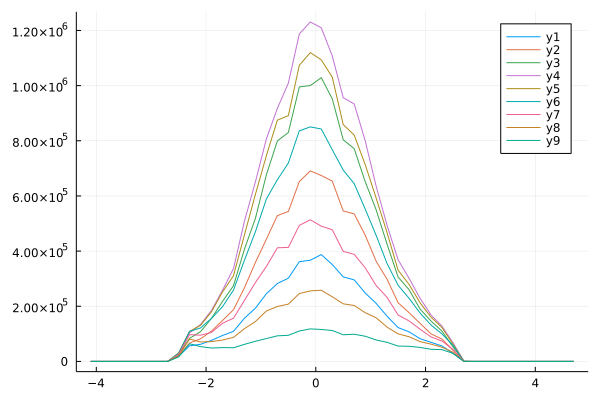

In [14]:

s2 = findfirst(x->x>λ2*1e6,λaxe);
plot(daxe,hlaser.weights[:,s2-4:s2+4])

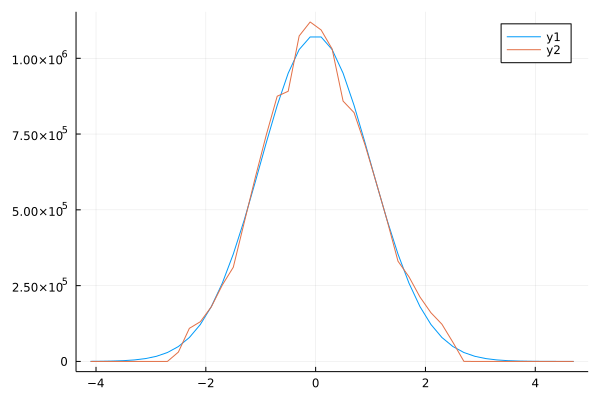

In [15]:
fittedlaser2 = curve_fit(m, daxe, hlaser.weights[:,s2], p0);
plot(daxe,hcat(m(daxe, fittedlaser2.param),hlaser.weights[:,s2]))

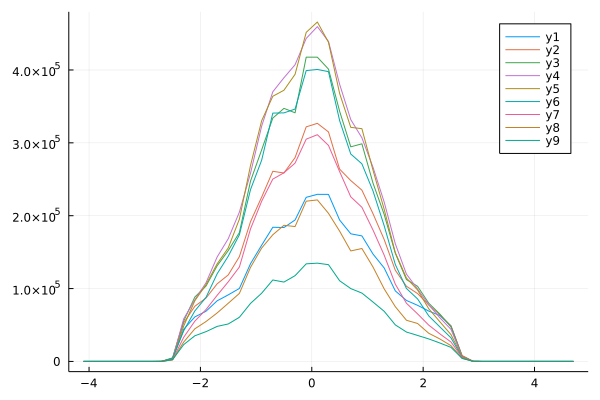

In [16]:

s3 = findfirst(x->x>λ3*1e6,λaxe);
plot(daxe,hlaser.weights[:,s3-4:s3+4])


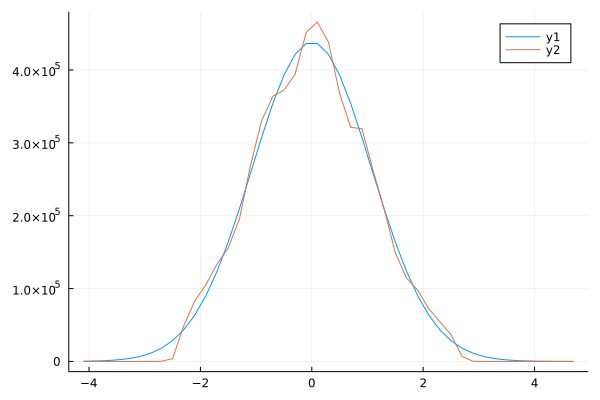

In [17]:
fittedlaser3 = curve_fit(m, daxe, hlaser.weights[:,s3], p0);
plot(daxe,hcat(m(daxe, fittedlaser3.param),hlaser.weights[:,s3]))

### Fitting flat 

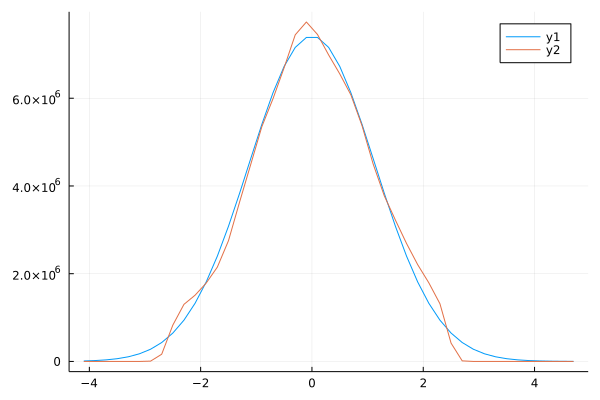

In [18]:

fittedflat1 = curve_fit(m, daxe, hflat.weights[:,s1], p0);
plot(daxe,hcat(m(daxe, fittedflat1.param),hflat.weights[:,s1]))

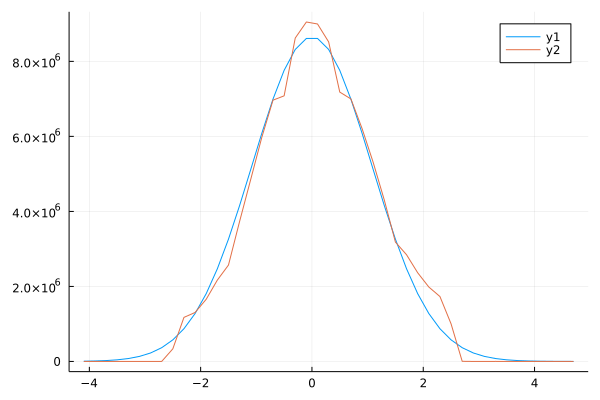

In [19]:

s2 = findfirst(x->x>λ2*1e6,λaxe);
fittedflat2 = curve_fit(m, daxe, hflat.weights[:,s2], p0);
plot(daxe,hcat(m(daxe, fittedflat2.param),hflat.weights[:,s2]))

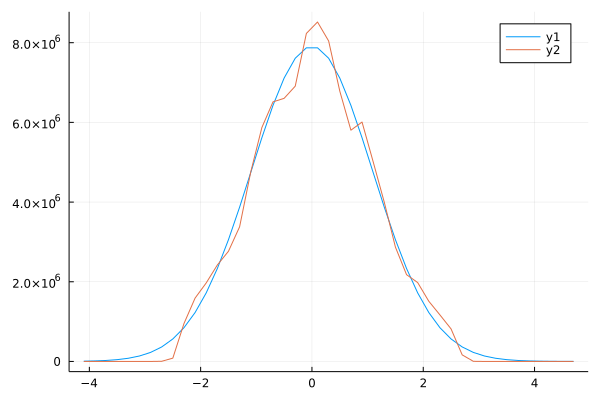

In [20]:

s3 = findfirst(x->x>λ3*1e6,λaxe);
fittedflat3 = curve_fit(m, daxe, hflat.weights[:,s3], p0);
plot(daxe,hcat(m(daxe, fittedflat3.param),hflat.weights[:,s3]))